In [22]:
# reload
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from scipy.stats import entropy
from npeet import entropy_estimators as ee

from utils.simulation import *
from utils.mutual import (compute_mutual_information_from_trajectories, mutual_information_slowjumps, MC_underhood, mutual_information_slowjumps_fixedw)
from utils.plotting import *
from utils.analytical import *

from utils.entropy_estimators import mi
from utils.gcmi import mi_mixture_gd, gcmi_mixture_cd

data_folder = 'data/'
folder_figures = 'figures/'
format_fig = '.svg'
lw = 2

/home/barzon/.local/lib/python3.8/site-packages/numba/core/errors.py:175: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
def get_default_params_system():
    ### Info system
    N = 2
    w = 4.
    k = 1.1
    tau_ei = 1
    r = np.ones(N)
    D = 0.05 #0.001
    
    return {'N': N, 'w': w, 'k': k, 'tau_ei': tau_ei, 'r': r, 'D': D}

def get_default_params_sims():
    ### Info simulation
    steps = int(5e6)
    dt = 0.05
    
    return {'steps': steps, 'dt': dt}

In [3]:
params = get_default_params_system()
params_sims = get_default_params_sims()

### Info input
M = 3
tau_h = 1000
wup = 1 / tau_h
wdown = 1 / tau_h
delta_h = 1. #0.15
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

In [4]:
### Create info dictionary
info_system = create_info_system(**params)
info_input = create_info_input(W, hs)
info_simulation = create_info_simulation(**params_sims)

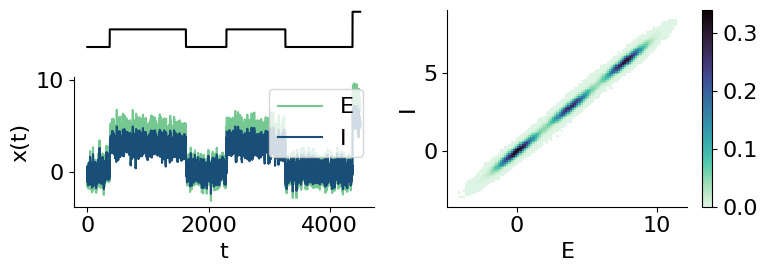

In [129]:
### Simulate state
inputs_slow, states_slow = simulate_coupled_system(info_system, info_input, info_simulation, seed=2)

plot_simulation(states_slow, inputs_slow, hs[0], params_sims['dt'], fname=None, max_steps_to_plot=int(9e4))

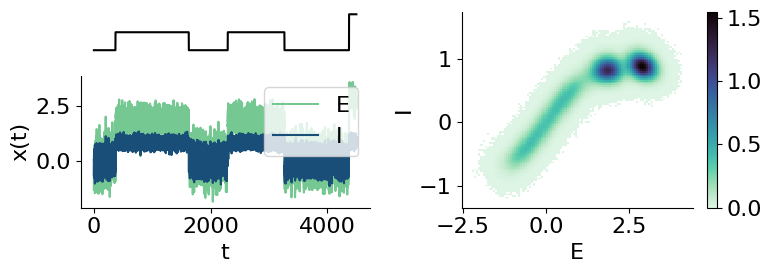

In [130]:
### Simulate state
inputs_slow_nonlinear, states_slow_nonlinear = simulate_coupled_system(info_system, info_input, info_simulation, seed=2, linear=False)

plot_simulation(states_slow_nonlinear, inputs_slow_nonlinear, hs[0], params_sims['dt'], fname=None, max_steps_to_plot=int(9e4))

In [131]:
mi_importance_sampling = MC_underhood(params['w'], params['k'], params['r'][0], params['D'], hs, p_stat, nsamples = int(1e5))

In [132]:
mi_importance_sampling / np.log(2)

1.5244527555321175

In [133]:
initial_transient=int(1e5)
steps_skip=5

print( ee.micd(states_slow[initial_transient:][::steps_skip], inputs_slow[initial_transient:][::steps_skip].reshape(-1,1)))
print( ee.micd(states_slow_nonlinear[initial_transient:][::steps_skip], inputs_slow_nonlinear[initial_transient:][::steps_skip].reshape(-1,1)))

1.503417486729417
1.461234513374222


### Varying k

In [5]:
def simulate_linear_nonlinear(ks, tau_h, delta_h, w, M = 3,
                              to_save=True, initial_transient=int(1e5), steps_skip=5, n_runs=10):
    params = get_default_params_system()
    params_sims = get_default_params_sims()

    params['w'] = w
    
    ### Info input
    wup = 1 / tau_h
    wdown = 1 / tau_h
    hs = np.arange(M) * delta_h
    hs = np.stack([hs, np.zeros(M)])
    W = create_transition_matrix_star_graph(M, wup, wdown)
    info_input = create_info_input(W, hs)

    p_stat = np.array([wdown] + [wup] * (M-1))
    p_stat = p_stat / p_stat.sum()

    res_linear = np.zeros((len(ks),n_runs))
    res_nonlinear = np.zeros((len(ks),n_runs))

    #traj_linear = []
    #traj_nonlinear = []

    ### Simulate
    for idx_k, k in enumerate(ks):
        print(f'[*] i={idx_k+1}/{ks.size}')
        params['k'] = k
        info_system = create_info_system(**params)
    
        for idx_run in range(n_runs):
            ### Simulate state
            inputs_slow, states_slow = simulate_coupled_system(info_system, info_input, info_simulation, seed=None)
            inputs_slow_nonlinear, states_slow_nonlinear = simulate_coupled_system(info_system, info_input, info_simulation, seed=None, linear=False)
    
            #traj_linear.append([inputs_slow, states_slow])
            #traj_nonlinear.append([inputs_slow_nonlinear, states_slow_nonlinear])
    
            ### Compute MI - github code
            try:
                res_linear[idx_k,idx_run] = ee.micd(states_slow[initial_transient:][::steps_skip], inputs_slow[initial_transient:][::steps_skip].reshape(-1,1))
            except:
                res_linear[idx_k,idx_run] = np.nan
            try:
                res_nonlinear[idx_k,idx_run] = ee.micd(states_slow_nonlinear[initial_transient:][::steps_skip], inputs_slow_nonlinear[initial_transient:][::steps_skip].reshape(-1,1))
            except:
                res_nonlinear[idx_k,idx_run] = np.nan
        
            '''
            ### Compute MI - mine code
            try:
                res_linear_mine[idx_k,idx_run] = compute_mutual_information_from_trajectories(states_slow[initial_transient:][::steps_skip], inputs_slow[initial_transient:][::steps_skip], bins)  / np.log(2)
            except:
                res_linear_mine[idx_k,idx_run] = np.nan
            try:
                res_nonlinear_mine[idx_k,idx_run] = compute_mutual_information_from_trajectories(states_slow_nonlinear[initial_transient:][::steps_skip], inputs_slow_nonlinear[initial_transient:][::steps_skip], bins)  / np.log(2)
            except:
                res_nonlinear_mine[idx_k,idx_run] = np.nan
            '''
    
    if to_save:
        np.save(f'data/mutual_linear_w_{w}_tau_{tau_h}_dh_{delta_h}_k_{ks[0]}_{ks[-1]}_{ks.size}.npy', res_linear)
        np.save(f'data/mutual_nonlinear_w_{w}_tau_{tau_h}_dh_{delta_h}_k_{ks[0]}_{ks[-1]}_{ks.size}.npy', res_nonlinear)
    
    return res_linear, res_nonlinear #, traj_linear, traj_nonlinear

In [6]:
from concurrent.futures import ThreadPoolExecutor

In [7]:
tau_hs = [1000, 500, 250]
delta_h = 1.
ks = np.linspace(0,4,20)

ws = [1, 2, 4, 6]

n_runs = 10

'''
def simulate_for_w(w):
    simulate_linear_nonlinear(ks, tau_h, delta_h, w)
    
for w in ws:
    print(f'w={w}')
    simulate_linear_nonlinear(ks, tau_h, delta_h, w)
'''

#'''
def simulate_for_w(w):
    simulate_linear_nonlinear(ks, tau_h, delta_h, w)

for tau_h in tau_hs:
    # Using ThreadPoolExecutor with a specified number of threads
    num_threads = len(ws)  # Adjust the number of threads as needed
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Map the `simulate_for_w` function to the list of `ws`
        executor.map(simulate_for_w, ws)
#'''    
   

'''
res_linear_all = []
res_nonlinear_all = []

for w in ws:
    res_linear = np.load(f'data/mutual_linear_w_{w}_tau_{tau_h}_dh_{delta_h}_k_{ks[0]}_{ks[-1]}_{ks.size}.npy')
    res_nonlinear = np.load(f'data/mutual_nonlinear_w_{w}_tau_{tau_h}_dh_{delta_h}_k_{ks[0]}_{ks[-1]}_{ks.size}.npy')
    
    res_linear_all.append(res_linear)
    res_nonlinear_all.append(res_nonlinear)
'''

'''
res_linear = np.zeros((len(tau_hs), len(ws), ks.size, n_runs))
res_nonlinear = np.zeros((len(tau_hs), len(ws), ks.size, n_runs))

for ih, tau_h in enumerate(tau_hs):
    for iw, w in enumerate(ws):
        tmp_res_linear = np.load(f'data/mutual_linear_w_{w}_tau_{tau_h}_dh_{delta_h}_k_{ks[0]}_{ks[-1]}_{ks.size}.npy')
        tmp_res_nonlinear = np.load(f'data/mutual_nonlinear_w_{w}_tau_{tau_h}_dh_{delta_h}_k_{ks[0]}_{ks[-1]}_{ks.size}.npy')
        
        res_linear[ih,iw] = tmp_res_linear
        res_nonlinear[ih,iw] = tmp_res_nonlinear
'''

[*] i=1/20
[*] i=1/20
[*] i=1/20
[*] i=1/20
[*] i=2/20
[*] i=2/20
[*] i=2/20
[*] i=2/20
[*] i=3/20
[*] i=3/20
[*] i=3/20
[*] i=4/20
[*] i=4/20
[*] i=4/20
[*] i=3/20
[*] i=5/20
[*] i=5/20
[*] i=4/20
[*] i=6/20
[*] i=6/20
[*] i=6/20
[*] i=5/20
[*] i=7/20
[*] i=7/20
[*] i=7/20
[*] i=6/20
[*] i=8/20
[*] i=8/20
[*] i=8/20
[*] i=7/20
[*] i=9/20
[*] i=9/20
[*] i=9/20
[*] i=8/20
[*] i=10/20
[*] i=10/20
[*] i=10/20
[*] i=9/20
[*] i=11/20
[*] i=11/20
[*] i=11/20
[*] i=10/20
[*] i=12/20
[*] i=12/20
[*] i=12/20
[*] i=11/20
[*] i=13/20
[*] i=13/20
[*] i=13/20
[*] i=12/20
[*] i=14/20
[*] i=14/20
[*] i=14/20
[*] i=13/20
[*] i=15/20
[*] i=15/20
[*] i=15/20
[*] i=14/20
[*] i=16/20
[*] i=16/20
[*] i=16/20
[*] i=15/20
[*] i=17/20
[*] i=17/20
[*] i=17/20
[*] i=18/20
[*] i=16/20
[*] i=18/20
[*] i=18/20
[*] i=17/20
[*] i=19/20
[*] i=19/20
[*] i=19/20
[*] i=20/20
[*] i=18/20
[*] i=20/20
[*] i=20/20
[*] i=19/20
[*] i=20/20
[*] i=1/20[*] i=1/20

[*] i=1/20
[*] i=1/20
[*] i=2/20
[*] i=2/20
[*] i=2/20
[*] i=2/20

"\nres_linear = np.zeros((len(tau_hs), len(ws), ks.size, n_runs))\nres_nonlinear = np.zeros((len(tau_hs), len(ws), ks.size, n_runs))\n\nfor ih, tau_h in enumerate(tau_hs):\n    for iw, w in enumerate(ws):\n        tmp_res_linear = np.load(f'data/mutual_linear_w_{w}_tau_{tau_h}_dh_{delta_h}_k_{ks[0]}_{ks[-1]}_{ks.size}.npy')\n        tmp_res_nonlinear = np.load(f'data/mutual_nonlinear_w_{w}_tau_{tau_h}_dh_{delta_h}_k_{ks[0]}_{ks[-1]}_{ks.size}.npy')\n        \n        res_linear[ih,iw] = tmp_res_linear\n        res_nonlinear[ih,iw] = tmp_res_nonlinear\n"

In [51]:
mi_imp_samp = np.zeros((len(ws), ks.size))

for i, w in enumerate(ws):
    params = get_default_params_system()
    params['w'] = w
    
    hs = np.arange(M) * delta_h
    hs = np.stack([hs, np.zeros(M)])
    
    mi_importance_sampling = mutual_information_slowjumps_fixedw(params['w'], ks, params['r'][0], params['D'], hs, p_stat, nsamples = int(1e5))
    mi_imp_samp[i] = mi_importance_sampling

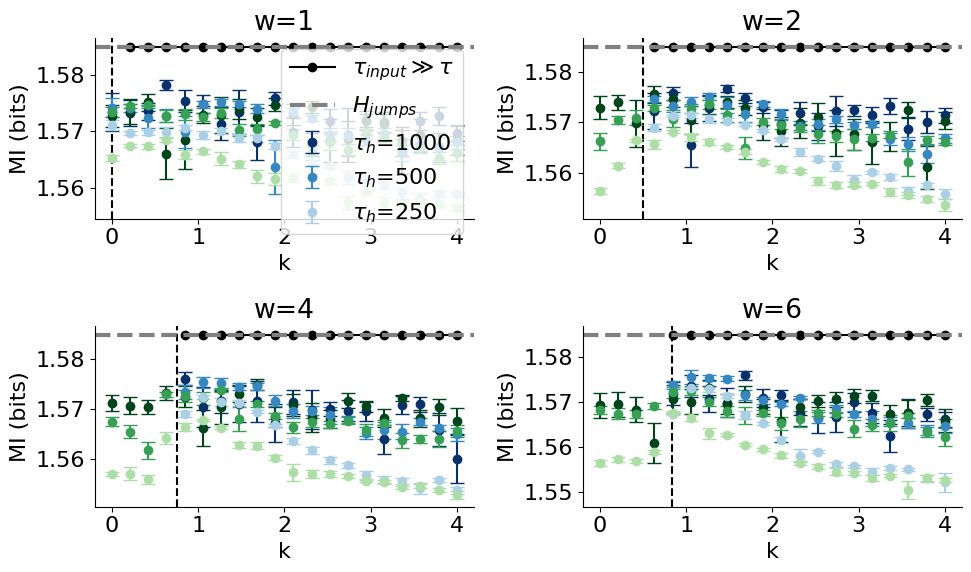

In [52]:
figsize=(10,6)
cmaps_lin = plt.get_cmap('Blues_r',len(tau_hs)+1)
cmaps_nonlin = plt.get_cmap('Greens_r',len(tau_hs)+1)

plt.figure(figsize=(10,6))

for i, w in enumerate(ws):
    mi_importance_sampling = mi_imp_samp[i]

    #plt.figure(figsize=(6,3))
    plt.subplot(2,len(ws)//2,i+1)
    
    for j, tau_h in enumerate(tau_hs):
        plt.errorbar(ks, res_linear[j,i].mean(axis=1), res_linear[j,i].std(axis=1) / np.sqrt(res_linear[j,i].shape[1]), label=r'$\tau_h$='+str(tau_h), fmt='o', capsize=5, c=cmaps_lin(j))
        plt.errorbar(ks, res_nonlinear[j,i].mean(axis=1), res_nonlinear[j,i].std(axis=1) / np.sqrt(res_linear[j,i].shape[1]), fmt='o', capsize=5, c=cmaps_nonlin(j))
    
    plt.plot(ks, mi_importance_sampling / np.log(2), '-o', label=r'$\tau_{input}\gg \tau$', c='k', zorder=0)

    plt.axvline(1-1/w, c='k', ls='--', zorder=-1)
    plt.axhline(entropy(p_stat) / np.log(2), c='gray', ls='--', lw=3, label=r'$H_{jumps}$', zorder=1)

    plt.xlabel('k')
    plt.ylabel('MI (bits)')
    plt.title(f'w={w}')

    if i==0: plt.legend()
        
plt.tight_layout()
sns.despine()
plt.show()        

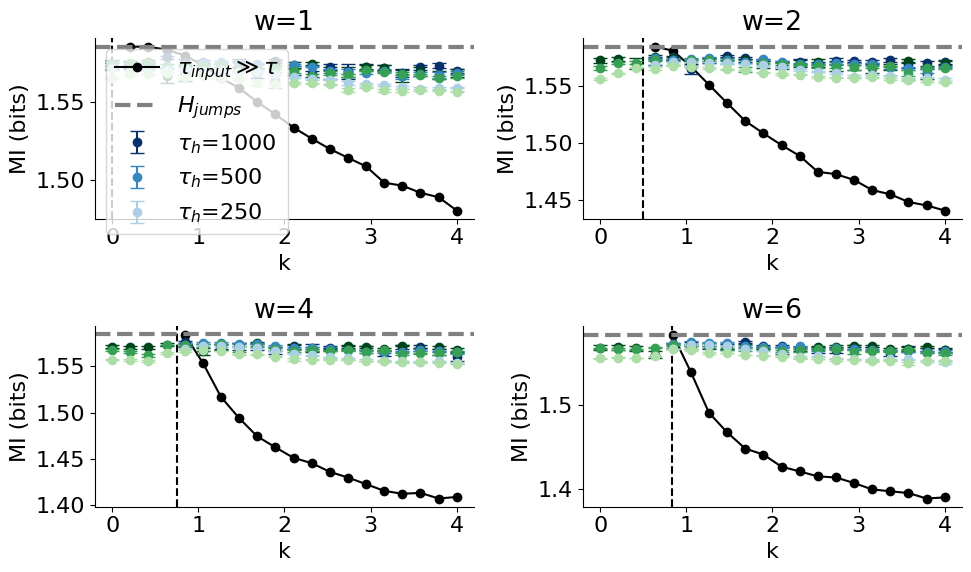

In [50]:
figsize=(10,6)
cmaps_lin = plt.get_cmap('Blues_r',len(tau_hs)+1)
cmaps_nonlin = plt.get_cmap('Greens_r',len(tau_hs)+1)

plt.figure(figsize=(10,6))

for i, w in enumerate(ws):
    mi_importance_sampling = mi_imp_samp[i]

    #plt.figure(figsize=(6,3))
    plt.subplot(2,len(ws)//2,i+1)
    
    for j, tau_h in enumerate(tau_hs):
        plt.errorbar(ks, res_linear[j,i].mean(axis=1), res_linear[j,i].std(axis=1) / np.sqrt(res_linear[j,i].shape[1]), label=r'$\tau_h$='+str(tau_h), fmt='o', capsize=5, c=cmaps_lin(j))
        plt.errorbar(ks, res_nonlinear[j,i].mean(axis=1), res_nonlinear[j,i].std(axis=1) / np.sqrt(res_nonlinear[j,i].shape[1]), fmt='o', capsize=5, c=cmaps_nonlin(j))
    
    plt.plot(ks, mi_importance_sampling / np.log(2), '-o', label=r'$\tau_{input}\gg \tau$', c='k', zorder=0)

    plt.axvline(1-1/w, c='k', ls='--', zorder=-1)
    plt.axhline(entropy(p_stat) / np.log(2), c='gray', ls='--', lw=3, label=r'$H_{jumps}$', zorder=1)

    plt.xlabel('k')
    plt.ylabel('MI (bits)')
    plt.title(f'w={w}')

    if i==0: plt.legend()
        
plt.tight_layout()
sns.despine()
plt.show()        

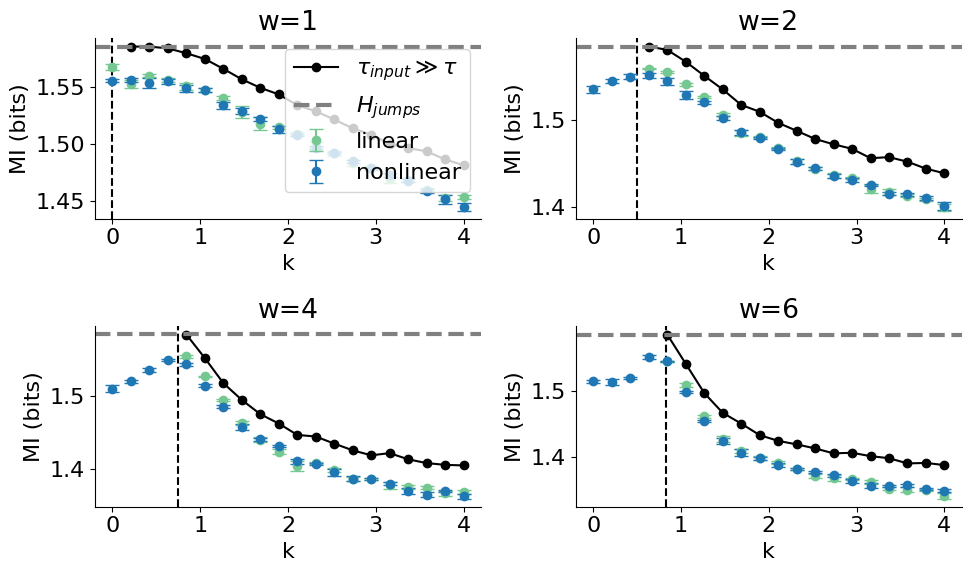

In [17]:
plt.figure(figsize=(10,6))

for i, w in enumerate(ws):
    res_linear = res_linear_all[i]
    res_nonlinear = res_nonlinear_all[i]
    
    params = get_default_params_system()
    params['w'] = w
    
    mi_importance_sampling = mutual_information_slowjumps_fixedw(params['w'], ks, params['r'][0], params['D'], hs, p_stat, nsamples = int(1e5))

    #plt.figure(figsize=(6,3))
    plt.subplot(2,len(ws)//2,i+1)

    plt.errorbar(ks, res_linear.mean(axis=1), res_linear.std(axis=1) / np.sqrt(res_linear.shape[1]), label='linear', fmt='o', capsize=5, c=colors[0])
    plt.errorbar(ks, res_nonlinear.mean(axis=1), res_nonlinear.std(axis=1) / np.sqrt(res_linear.shape[1]), label='nonlinear', fmt='o', capsize=5)
    plt.plot(ks, mi_importance_sampling / np.log(2), '-o', label=r'$\tau_{input}\gg \tau$', c='k', zorder=0)

    plt.axvline(1-1/params['w'], c='k', ls='--', zorder=-1)
    plt.axhline(entropy(p_stat) / np.log(2), c='gray', ls='--', lw=3, label=r'$H_{jumps}$', zorder=1)

    plt.xlabel('k')
    plt.ylabel('MI (bits)')
    plt.title(f'w={w}')

    if i==0:
        plt.legend()
    
plt.tight_layout()
sns.despine()
plt.show()

In [33]:
tau_hs = [50, 100, 200, 400]
delta_h = 0.15
ks = np.linspace(0,4,30)
w = 4

'''
def simulate_for_w(w):
    simulate_linear_nonlinear(ks, tau_h, delta_h, w)

# Using ThreadPoolExecutor with a specified number of threads
num_threads = len(ws)  # Adjust the number of threads as needed
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    # Map the `simulate_for_w` function to the list of `ws`
    executor.map(simulate_for_w, ws)
'''

res_linear_all = []
res_nonlinear_all = []

for tau_h in tau_hs:
    res_linear = np.load(f'data/mutual_linear_w_{w}_tau_{tau_h}_dh_{delta_h}_k_{ks[0]}_{ks[-1]}_{ks.size}.npy')
    res_nonlinear = np.load(f'data/mutual_nonlinear_w_{w}_tau_{tau_h}_dh_{delta_h}_k_{ks[0]}_{ks[-1]}_{ks.size}.npy')
    
    res_linear_all.append(res_linear)
    res_nonlinear_all.append(res_nonlinear)

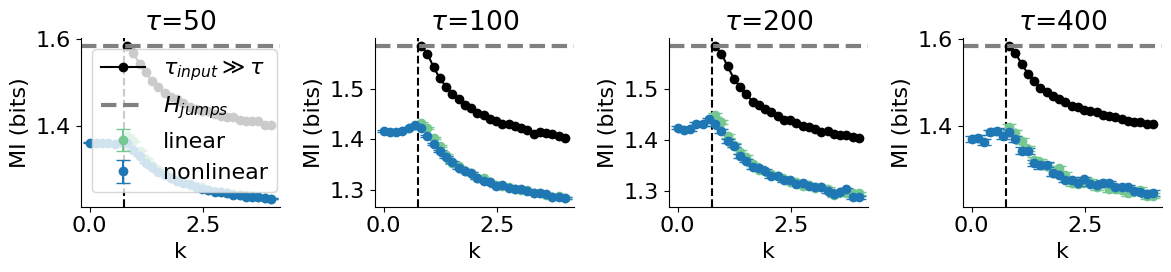

In [42]:
plt.figure(figsize=(12,3))

for i, tau_h in enumerate(tau_hs):
    res_linear = res_linear_all[i]
    res_nonlinear = res_nonlinear_all[i]
    
    params = get_default_params_system()
    params['w'] = w
    
    mi_importance_sampling = mutual_information_slowjumps_fixedw(params['w'], ks, params['r'][0], params['D'], hs, p_stat, nsamples = int(1e5))

    #plt.figure(figsize=(6,3))
    plt.subplot(1,len(tau_hs),i+1)

    plt.errorbar(ks, res_linear.mean(axis=1), res_linear.std(axis=1) / np.sqrt(res_linear.shape[1]), label='linear', fmt='o', capsize=5, c=colors[0])
    plt.errorbar(ks, res_nonlinear.mean(axis=1), res_nonlinear.std(axis=1) / np.sqrt(res_linear.shape[1]), label='nonlinear', fmt='o', capsize=5)
    plt.plot(ks, mi_importance_sampling / np.log(2), '-o', label=r'$\tau_{input}\gg \tau$', c='k', zorder=0)

    plt.axvline(1-1/params['w'], c='k', ls='--', zorder=-1)
    plt.axhline(entropy(p_stat) / np.log(2), c='gray', ls='--', lw=3, label=r'$H_{jumps}$', zorder=1)

    plt.xlabel('k')
    plt.ylabel('MI (bits)')
    plt.title(r'$\tau$='+str(tau_h))

    if i==0:
        plt.legend()
    
plt.tight_layout()
sns.despine()
plt.show()

In [ ]:
tau_h = 200
delta_h = 0.15
ks = np.linspace(0,4,30)

ws = [2, 4, 6, 8]

for w in ws:
    simulate_linear_nonlinear(ks, tau_h, delta_h, w)

[*] i=1/30


In [ ]:
tau_h = 200
ks = np.linspace(0,4,30)
w = 4

dhs = [0.3, 0.5, 1.]

for delta_h in dhs:
    simulate_linear_nonlinear(ks, tau_h, delta_h, w)

In [72]:
print('ciao')

ciao


In [23]:
### Define arrays
tau_h = 50
ks = np.linspace(0, 4, 20)
res_linear, res_nonlinear, traj_linear, traj_nonlinear = simulate_linear_nonlinear(ks)
mi_importance_sampling = mutual_information_slowjumps_fixedw(params['w'], ks, params['r'][0], params['D'], hs, p_stat, nsamples = int(1e5))

[*] i=1/20
[*] i=2/20
[*] i=3/20
[*] i=4/20
[*] i=5/20
[*] i=6/20
[*] i=7/20
[*] i=8/20
[*] i=9/20
[*] i=10/20
[*] i=11/20
[*] i=12/20
[*] i=13/20
[*] i=14/20
[*] i=15/20
[*] i=16/20
[*] i=17/20
[*] i=18/20
[*] i=19/20
[*] i=20/20


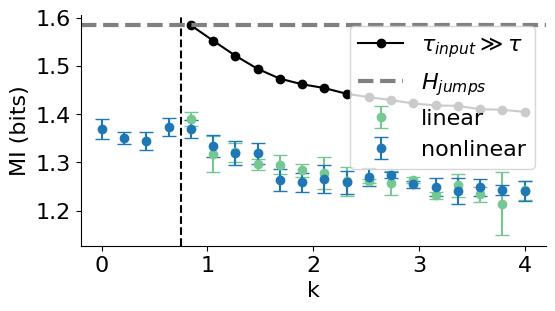

In [28]:
plt.figure(figsize=(6,3))

plt.errorbar(ks, res_linear.mean(axis=1), res_linear.std(axis=1), label='linear', fmt='o', capsize=5, c=colors[0])
plt.errorbar(ks, res_nonlinear.mean(axis=1), res_nonlinear.std(axis=1), label='nonlinear', fmt='o', capsize=5)
plt.plot(ks, mi_importance_sampling / np.log(2), '-o', label=r'$\tau_{input}\gg \tau$', c='k', zorder=0)

plt.axvline(1-1/params['w'], c='k', ls='--', zorder=-1)
plt.axhline(entropy(p_stat) / np.log(2), c='gray', ls='--', lw=3, label=r'$H_{jumps}$', zorder=1)

plt.xlabel('k')
plt.ylabel('MI (bits)')

plt.legend()
sns.despine()
plt.show()

K=0.0


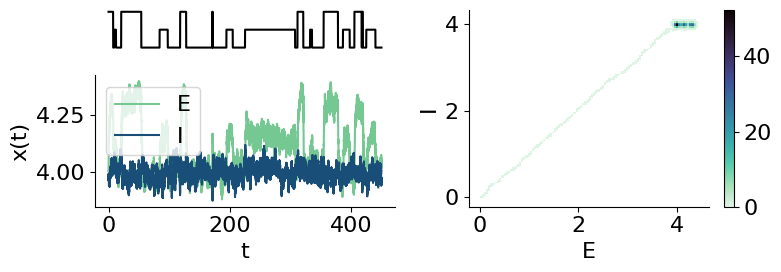

K=0.21052631578947367


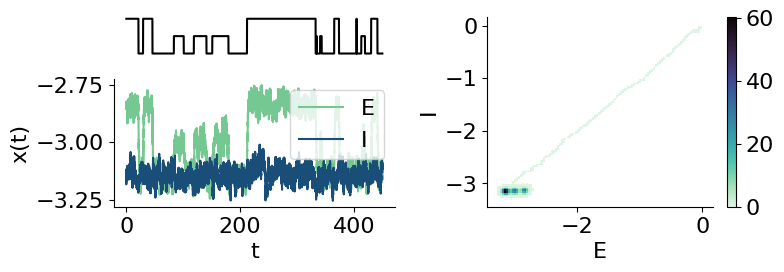

K=0.42105263157894735


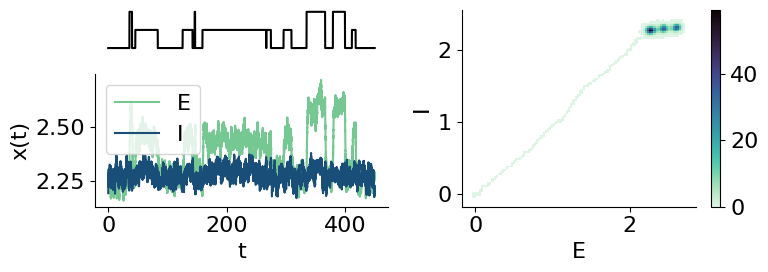

K=0.631578947368421


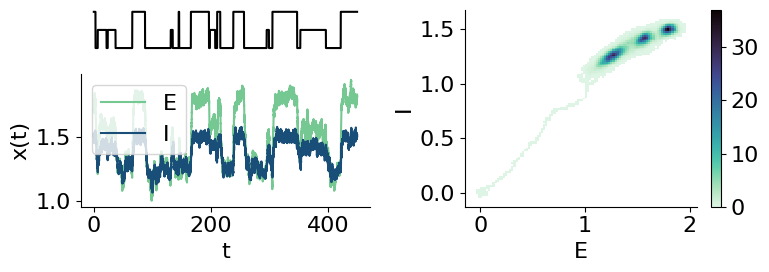

K=0.8421052631578947


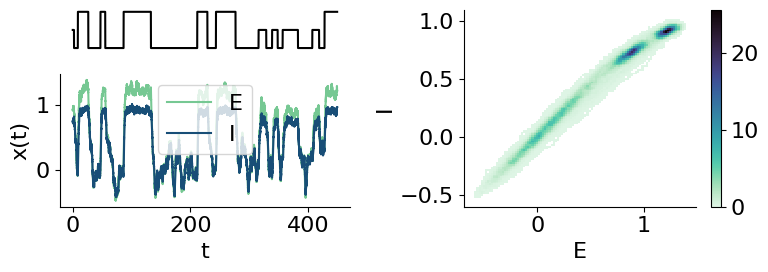

K=1.0526315789473684


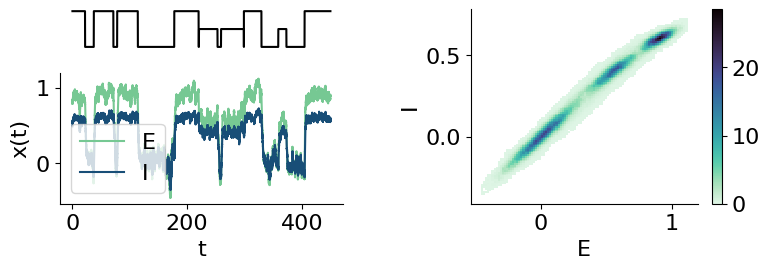

K=1.263157894736842


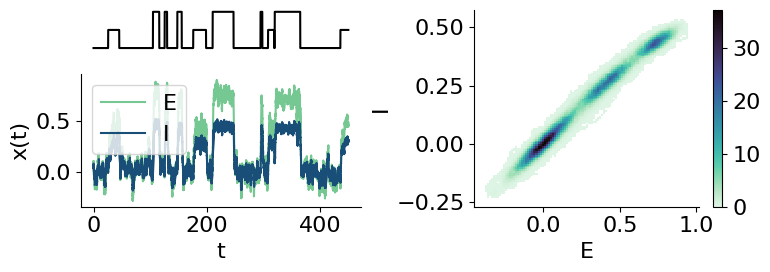

K=1.4736842105263157


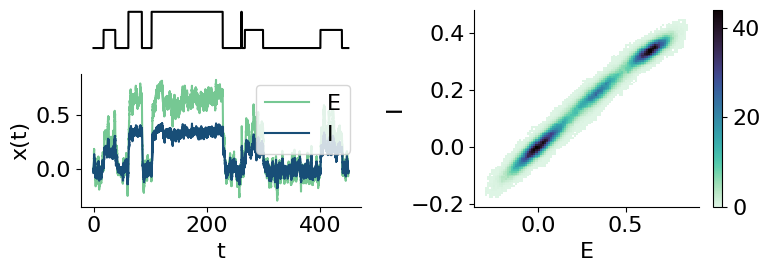

K=1.6842105263157894


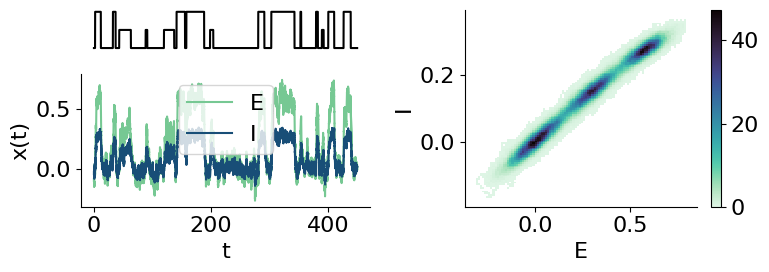

K=1.894736842105263


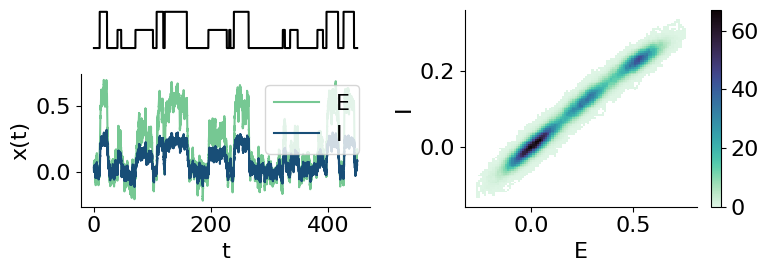

K=2.1052631578947367


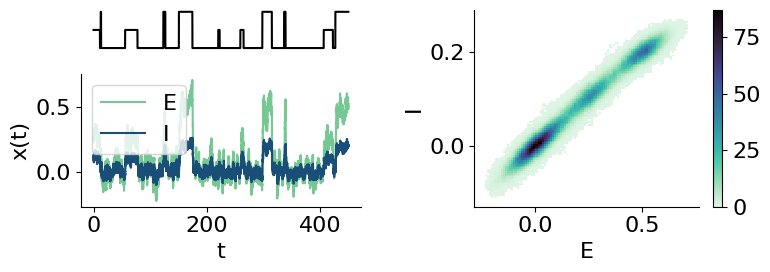

K=2.3157894736842106


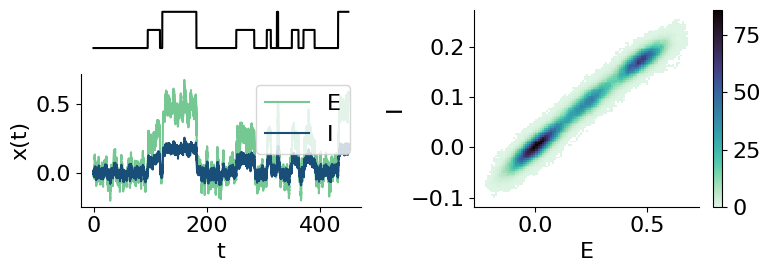

K=2.526315789473684


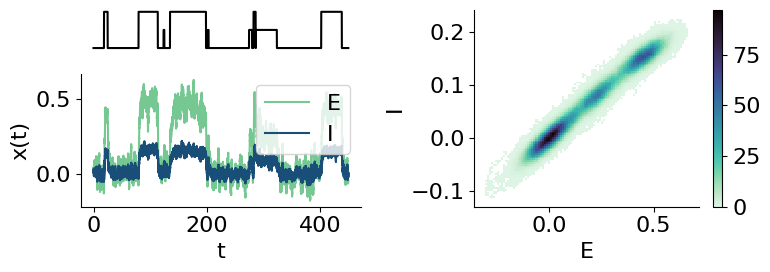

K=2.7368421052631575


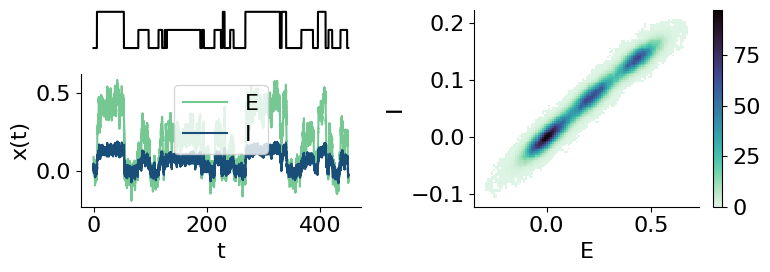

K=2.9473684210526314


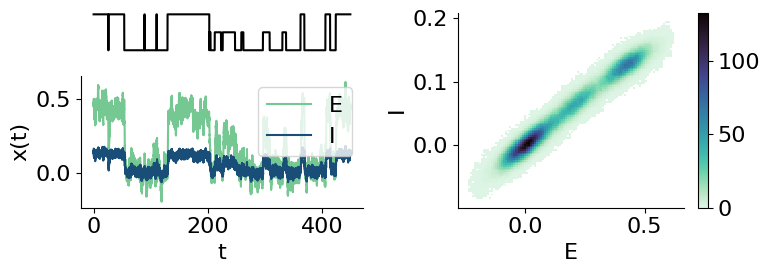

K=3.1578947368421053


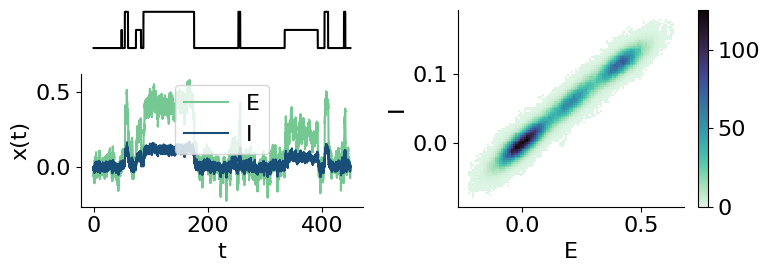

K=3.3684210526315788


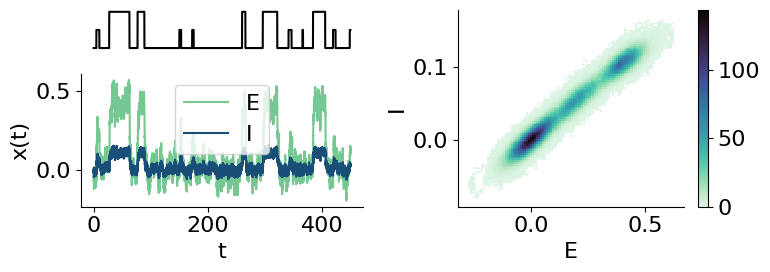

K=3.578947368421052


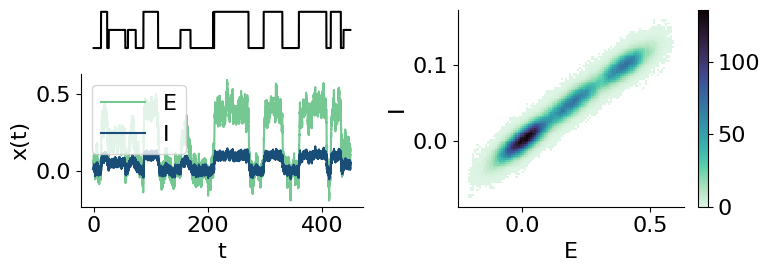

K=3.789473684210526


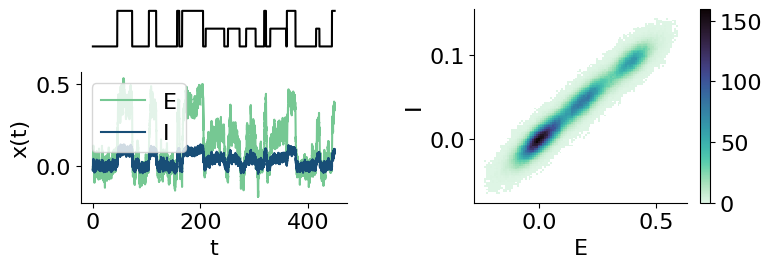

K=4.0


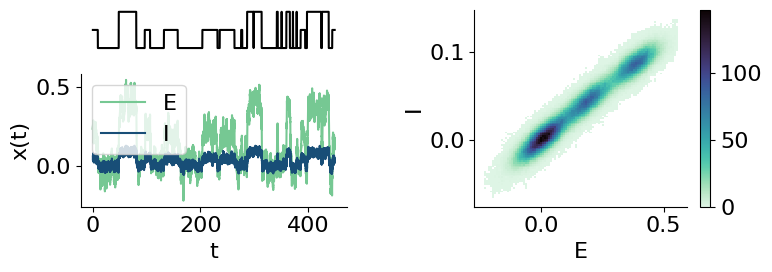

In [159]:
for idx, traj in enumerate(traj_nonlinear):
    if idx % n_runs:
        continue
    print(f'K={ks[idx//n_runs]}')
    plot_simulation(traj[1], traj[0], hs[0], dt, fname=None, max_steps_to_plot=int(9e4))